In [19]:
# pip install transformers==4.30.1 onnx onnxruntime

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 46.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 64.2 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.

In [22]:
import os
import torch
import torch.nn as nn

import albumentations as A
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import BeitForImageClassification, SwinForImageClassification, ViTForImageClassification, ViTConfig
from torch.optim import AdamW
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, f1_score

from torch.cuda.amp import autocast, GradScaler
from transformers import BeitImageProcessor
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import json

In [2]:
torch.__version__

'2.0.1+cu118'

Создаем переменные конфигурации

In [3]:
train_path = "split_dataset/train"
val_path = "split_dataset/val"
test_path = "split_dataset/test"

In [4]:
# Конфигурация
config = {
    "model_name": "google/vit-base-patch16-224",
    "img_size": 224,
    "batch_size": 64,
    "epochs": 10,
    "lr": 3e-5,
    "num_workers": 4,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}


In [ ]:
def f(x, y, w, h):
  if x >= 1000 and y >= 1000:
    return -1
  if x+w < 0 and y+h < 0:
    return -1
  if x < 1000 and x+h > 1000 and y < 1000 and y+w > 1000:
    return [(x, y), (1000, 1000)]
  if x < 1000 and x+h <= 1000 and y < 1000 and y+w <= 1000:  
    return [(x, y), (x+w, y+h)]

f(-200, -200, 1000, 800)

Создаем аугментационный пайплайн

In [5]:
# Аугментации с Albumentations
train_transform = A.Compose([
    A.Resize(config['img_size'], config['img_size']),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=20, p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # BEiT-specific normalization
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(config['img_size'], config['img_size']),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(config['img_size'], config['img_size']),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

Создание датасета

In [6]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.get_class = {i: cls for i, cls in enumerate(self.classes)}
        self.samples = []
        self.transform = transform

        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                self.samples.append((
                    os.path.join(cls_dir, img_name),
                    self.class_to_idx[cls]
                ))
        self.targets = np.unique([label for _, label in self.samples])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = np.array(Image.open(img_path).convert("RGB"))

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        return image, torch.tensor(label, dtype=torch.long)

In [7]:
# Инициализация данных
train_dataset = CustomDataset(
    train_path,
    transform=train_transform
)
val_dataset = CustomDataset(
    val_path,
    transform=val_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers']
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers']
)

Загрузка модели и добавление регуляризации

In [8]:
model_config = ViTConfig.from_pretrained(
    config['model_name'],
    num_labels=len(train_dataset.classes)
)
model_config.hidden_dropout_prob = 0.2               
model_config.attention_probs_dropout_prob = 0.1      

model = ViTForImageClassification.from_pretrained(
    config['model_name'],
    config=model_config,
    ignore_mismatched_sizes=True
).to(config["device"])

/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([144]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([144, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Балансировка лосс-функции

In [9]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(train_dataset.classes)),
    y=train_dataset.targets  # или y=все метки train датасета
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(config['device'])

# 3. Заменяем встроенный лосс
model.loss = nn.CrossEntropyLoss(weight=weights_tensor)

Создание оптимизатора

In [11]:
optimizer = AdamW([
    {"params": model.vit.parameters(), "lr": 3e-5},
    {"params": model.classifier.parameters(), "lr": 2e-4},
], weight_decay=0.01)

Обучение модели

In [12]:
def train_model(model, train_loader, val_loader, optimizer, config):
    device = config['device']
    epochs = config['epochs']
    scaler = GradScaler()

    history = {'train_loss': [], 'val_loss': [],
               'train_acc': [], 'val_acc': [],
               'train_f1': [], 'val_f1': []}
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []

        with tqdm(train_loader,
                  unit="batch",
                  desc=f"Epoch {epoch+1}/{epochs} [Train]") as tepoch:
            for images, labels in tepoch:
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with autocast():
                    outputs = model(pixel_values=images, labels=labels)
                    loss = outputs.loss
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                # loss.backward()
                # optimizer.step()

                train_loss += loss.item()
                preds = torch.argmax(outputs.logits, dim=1)

                train_preds.extend(preds.cpu().numpy())
                train_labels.extend(labels.cpu().numpy())
                tepoch.set_postfix({
                    'loss': loss.item(),
                    'acc': accuracy_score(train_labels, train_preds),
                    'f1': f1_score(train_labels, train_preds, average='weighted')
                })

        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []

        with torch.no_grad(), tqdm(val_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs} [Val]") as tepoch:
            for images, labels in tepoch:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(pixel_values=images, labels=labels)
                val_loss += outputs.loss.item()

                preds = torch.argmax(outputs.logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

                tepoch.set_postfix({
                    'val_loss': loss.item(),
                    'val_acc': accuracy_score(val_labels, val_preds),
                    'val_f1': f1_score(val_labels, val_preds, average='weighted')
                })

        # Метрики
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        val_acc = accuracy_score(val_labels, val_preds)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

    return history

Вывод и сохранение метрик во время обучения

In [13]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(18, 5))

    # 1. Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # 2. Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    # 3. F1-score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_f1'], label='Train F1')
    plt.plot(epochs, history['val_f1'], label='Val F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.title('F1-score per Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("vit_history.png")
    plt.show()

In [ ]:
history = train_model(model, train_loader, val_loader, optimizer, config)

Epoch 10/10 [Val]: 100%|██████████| 747/747 [04:48<00:00,  2.59batch/s, val_loss=2.11, val_acc=0.321, val_f1=0.307]


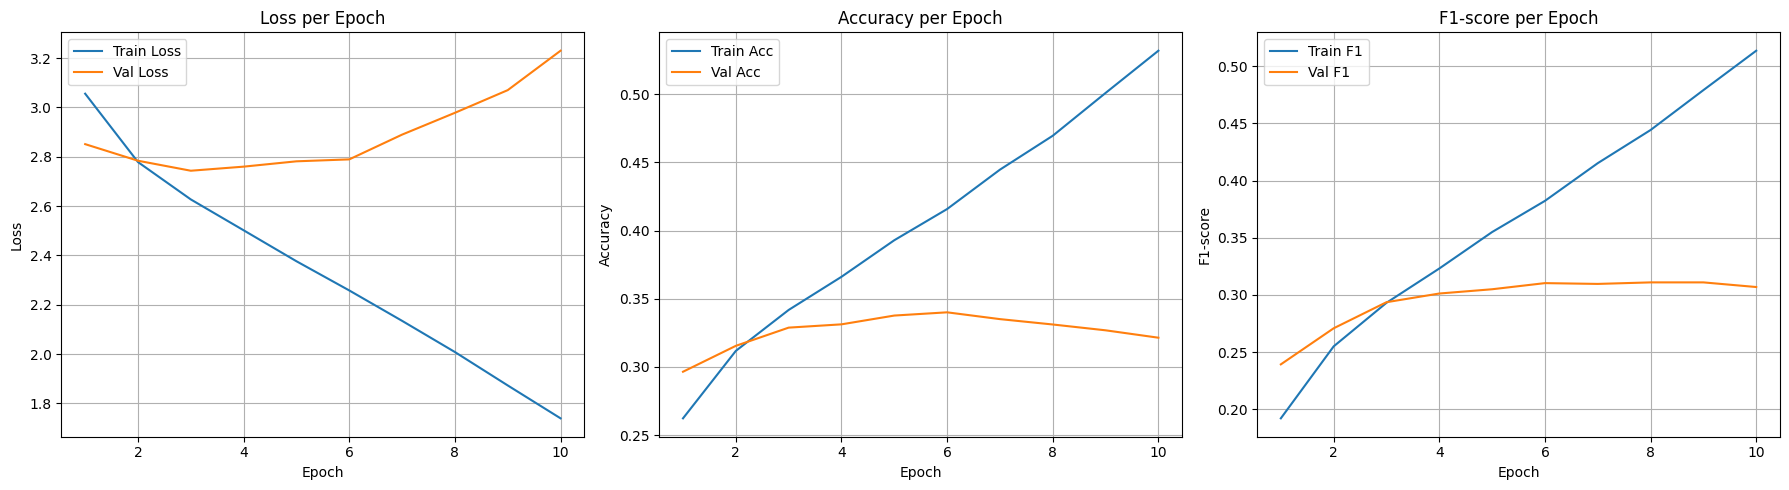

In [ ]:
plot_training_history(history)

Сохранение модели

In [20]:
model.eval().cpu()
dummy_input = torch.randn(1, 3, 224, 224)
torch.onnx.export(
    model,
    dummy_input,
    "vit_model.onnx",
    input_names=["pixel_values"],
    output_names=["logits"],
    dynamic_axes={"pixel_values": {0: "batch_size"}, "logits": {0: "batch_size"}},
    opset_version=11
)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [23]:
# Сохранение словаря id название класса в файл
with open('vocab.json', 'w', encoding='utf-8') as f:
    json.dump(train_dataset.get_class, f, ensure_ascii=False, indent=4)